# 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
!pwd
!ls -la

/Users/maxburger/code/MadMax1995bb/powder_alert2.0/notebooks
total 928
drwxr-xr-x   8 maxburger  staff     256 Dec 10 14:19 .
drwxr-xr-x  19 maxburger  staff     608 Dec 10 11:54 ..
-rw-r--r--   1 maxburger  staff       0 Dec 10 08:36 .keep
-rw-r--r--   1 maxburger  staff  264154 Dec 10 11:50 Wisal_notebook.ipynb
-rw-r--r--   1 maxburger  staff   11202 Dec 10 11:50 alternative_notebook.ipynb
-rw-r--r--   1 maxburger  staff   59870 Dec 10 11:50 notebook_Anita-Gei_get_openmeteo_data.ipynb
-rw-r--r--@  1 maxburger  staff   87525 Dec 10 23:35 notebook_MadMax1995bb.ipynb
-rw-r--r--@  1 maxburger  staff   42873 Dec 10 14:19 notebook_model_tests.ipynb


# 1. Data Import & Cleaning

In [3]:
current_dir = os.getcwd()
relative_path = os.path.dirname(current_dir)
file_name = "raw_data/historical_weather_openmeteo_01011979-08122024.csv"

file_path = os.path.join(relative_path, file_name)

df_openmeteo = pd.read_csv(file_path, parse_dates=['date'])

In [4]:
df_openmeteo['date'] = df_openmeteo['date'].dt.tz_localize(None) # remove the UTC

In [5]:
df_openmeteo.dtypes

date                             datetime64[ns]
temperature_2m                          float64
relative_humidity_2m                    float64
dew_point_2m                            float64
apparent_temperature                    float64
precipitation                           float64
rain                                    float64
snowfall                                float64
snow_depth                              float64
weather_code                            float64
pressure_msl                            float64
surface_pressure                        float64
cloud_cover                             float64
cloud_cover_low                         float64
cloud_cover_mid                         float64
cloud_cover_high                        float64
et0_fao_evapotranspiration              float64
vapour_pressure_deficit                 float64
wind_speed_10m                          float64
wind_speed_100m                         float64
wind_direction_10m                      

In [6]:
df_openmeteo.shape

(402696, 32)

In [7]:
df_openmeteo.tail(2)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,sunshine_duration
402694,2024-12-08 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402695,2024-12-08 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


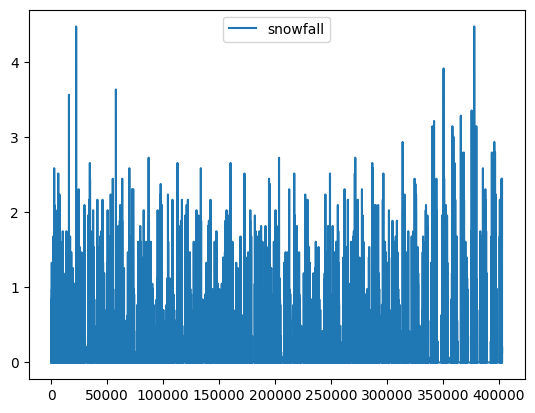

In [8]:
df_openmeteo.plot(y='snowfall');

In [9]:
df = df_openmeteo[df_openmeteo['date'] < '2024-12-08 00:00:00']
df = df.drop_duplicates()
df = df.dropna()

In [10]:
df.shape

(402072, 32)

# 2. Encoding/ pre-processing

In [11]:
df = df.drop(columns='date')
df.shape

(402072, 31)

In [12]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 3. Create Sequences for predictions

In [15]:
# Prepare sequences for time-series forecasting
def create_sequences(data, target_col, sequence_length, forecast_horizon):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        sequence = data.iloc[i:i + sequence_length].values
        target = data.iloc[i + sequence_length + forecast_horizon - 1][target_col]  # The target value to predict
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Set the sequence length (e.g., past 48 hours) and the forecast horizon (e.g., 48 hours ahead)
sequence_length = 48
forecast_horizon = 48

# 4.1 Model variables

In [25]:
sampled_df = df_scaled.sample(frac=0.2, random_state=42)

In [42]:
features = sampled_df.drop(columns='soil_moisture_0_to_7cm')
df_features = sampled_df

In [43]:
X, y = create_sequences(df_features,
                        target_col='soil_moisture_0_to_7cm',
                        sequence_length=sequence_length,
                        forecast_horizon=forecast_horizon)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 0.2 Imports

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 4.2 Model creation & fitting

In [46]:
model = Sequential()

model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

/Users/maxburger/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,049 (320.50 KB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - loss: 0.0384 - mae: 0.1600 - val_loss: 0.0296 - val_mae: 0.1450
Epoch 2/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - loss: 0.0310 - mae: 0.1473 - val_loss: 0.0294 - val_mae: 0.1441
Epoch 3/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - loss: 0.0305 - mae: 0.1464 - val_loss: 0.0299 - val_mae: 0.1460
Epoch 4/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.0302 - mae: 0.1456 - val_loss: 0.0293 - val_mae: 0.1437
Epoch 5/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - loss: 0.0297 - mae: 0.1445 - val_loss: 0.0295 - val_mae: 0.1449


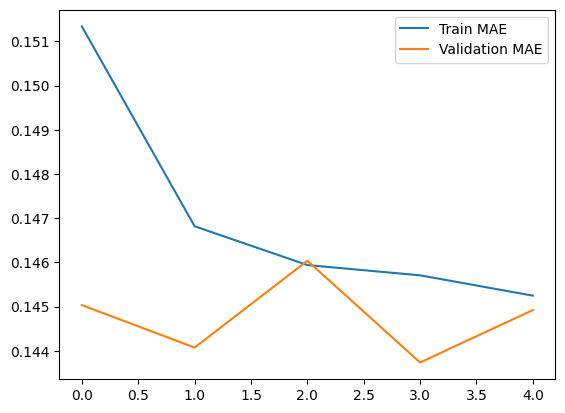

In [54]:
plt.plot(history.history["mae"], label = "Train MAE")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.legend();

# 5. Evaluate and predict

In [55]:
model_mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Model Mean Absolute Error {model_mae[1]:.4f}')

Model Mean Absolute Error 0.1437


# Baseline comparison

In [58]:
# Using the last soil_moisture_0_to_7cm in X to predict the next soil_moisture_0_to_7cm
y_test_baseline = X_test[:, -1, 0]
mae_baseline = np.mean(np.abs(y_test - y_test_baseline))

print(f'Baseline MAE = {mae_baseline:.3f}')
print("vs.")
print(f'RNN MAE = {model_mae[1]:.3f}')

Baseline MAE = 0.176
vs.
RNN MAE = 0.144


In [1]:
df

NameError: name 'df' is not defined